<a href="https://colab.research.google.com/github/TheEmotionalProgrammer/CloudDetectionThesis/blob/main/tesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#MONTO IL DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#FUNZIONI PER LA LETTURA E SCRITTURA DI IMMAGINI TIFF

from osgeo import gdal
gdal.VersionInfo()
import numpy as np

list1 = ["byte","uint8","uint16","int16","uint32","int32","float32","float64","cint16","cint32","cfloat32","cfloat64"]
list2 = [gdal.GDT_Byte,gdal.GDT_Byte,gdal.GDT_UInt16,gdal.GDT_Int16,gdal.GDT_UInt32,gdal.GDT_Int32,gdal.GDT_Float32,gdal.GDT_Float64,gdal.GDT_CInt16,gdal.GDT_CInt32,gdal.GDT_CFloat32,gdal.GDT_CFloat64]

def imgread(path):
    img = gdal.Open(path)
    # col = img.RasterXSize #col
    # row = img.RasterYSize #row
    # img_arr = img.ReadAsArray(0,0,col,row)
    c = img.RasterCount
    img_arr = img.ReadAsArray()
    if c>1:
        img_arr = img_arr.swapaxes(1,0)
        img_arr = img_arr.swapaxes(2,1)
    del img
    return img_arr

def imgwrite(path,narray,compress="None"):
    s=narray.shape
    dt_name=narray.dtype.name
    for i in range(len(list1)):
        if list1[i] in dt_name.lower():
            datatype=list2[i]
            break
        else:
            datatype=list2[0]

    if len(s)==2:
        row,col,c=s[0],s[1],1
        driver = gdal.GetDriverByName('GTiff')
        dataset = driver.Create(path,col,row,c,datatype,options=["COMPRESS="+compress])
        dataset.GetRasterBand(1).WriteArray(narray)
        del dataset
    elif len(s)==3:
        row,col,c = s[0], s[1], s[2]
        driver = gdal.GetDriverByName('GTiff')
        dataset = driver.Create(path,col,row, c, datatype)
        for i in range(c):
            dataset.GetRasterBand(i + 1).WriteArray(narray[:,:,i])
        del dataset



In [ ]:
#FUNZIONI FONDAMENTALI PER VISUALIZZARE BENE LE IMMAGINI
def cv_inv_proc(img):
    img_rgb = (img+1)*127.5
    return img_rgb.astype(np.float32)
def acv_inv_proc(img):
    img_rgb = img*255.0
    return img_rgb.astype(np.float32)
def get_normal_picture(image):
    image = image.numpy()

    image= image[[0,1,2],:,:]
    low,high=np.percentile(image,(2,98))
    image[low> image]=low
    image[image>high]=high
    rescaled_img=(image-low)/(high-low)
    x_image = acv_inv_proc(rescaled_img)

    return torch.tensor(np.uint8(x_image))

In [ ]:
#FUSIONE DEI FILE SAFE

import numpy as np
import os
import glob


'''
The source zip file should be unziped and organized as follows:
sourcedir
        /S2A_MSIL1C_20180429T032541_N0206_R018_T49SCV_20180429T062304.SAFE
                                                                          /AUX_DATA...
        /S2A_MSIL1C_20180722T030541_N0206_R075_T49RFP_20180722T060550.SAFE
                                                                          /AUX_DATA...
'''
testlist=["S2A_MSIL1C_20180930T030541_N0206_R075_T49QDD_20180930T060706",
"S2A_MSIL1C_20191105T023901_N0208_R089_T51STR_20191105T054744",
"S2A_MSIL1C_20190812T032541_N0208_R018_T48RXU_20190812T070322",
"S2A_MSIL1C_20190602T021611_N0207_R003_T52TES_20190602T042019",
"S2A_MSIL1C_20190328T033701_N0207_R061_T49TCF_20190328T071457",
"S2A_MSIL1C_20191001T050701_N0208_R019_T45TXN_20191002T142939",
"S2A_MSIL1C_20200416T042701_N0209_R133_T46SFE_20200416T074050",
"S2A_MSIL1C_20200528T050701_N0209_R019_T44SPC_20200528T082127",
"S2A_MSIL1C_20210207T023851_N0209_R089_T52UCU_20210207T040210",
"S2A_MSIL1C_20210126T052111_N0209_R062_T44SNE_20210126T063836",
"S2A_MSIL1C_20210102T054231_N0209_R005_T43SFB_20210102T065941",
"S2A_MSIL1C_20201206T041141_N0209_R047_T47SMV_20201206T053320"]

#sourcedir='F:/WHU/WHUS2-CD+/'#sourcedir
sourcedir =os.getcwd()+  '/WHUS2-CD+/'
name='unziped'
sourcepath=sourcedir+name#the unziped file path
savepath=sourcedir#savepath
bands = [['10m','02','03','04','08']]#,['20m','05','06','07','8A','11','12'],['60m','01','09','10']]
def fuse_DN(path1):
    filename=path1.split('\\')[-1].split('/')[-1][:-5]
    filename = os.path.basename(filename)
    if filename in testlist:
        savepath=sourcedir+"test"
    else:
        savepath=sourcedir+"train"
    print(filename)

    filedir1=glob.glob(os.path.join(path1, 'GRANULE'))[0]
    filedir2=glob.glob(os.path.join(filedir1, 'L*'))[0]
    filedir3=glob.glob(os.path.join(filedir2, 'IMG_DATA'))[0]
    for k in range(len(bands)):
        savedir=savepath+"/"+str(bands[k][0])
        if not os.path.exists(savedir):
            os.makedirs(savedir)
        if os.path.exists(savedir+"/"+filename+'.tif'):
            continue
        Img_concat=[]
        for i in range(1,len(bands[k])):
            filepath=glob.glob(os.path.join(filedir3, '*'+str(bands[k][i])+'.jp2'))[0]
            img = imgread(filepath)
            DN_img=img[:,:,np.newaxis]
            Img_concat.append(DN_img)
        fusedimg = np.concatenate(Img_concat,axis=2)
        print(fusedimg.shape)

        imgwrite(savedir+"/"+filename+'.tif',fusedimg)

def multi_dir(path):
    filedirs=glob.glob(os.path.join(path, 'S2*'))
    for i in range(len(filedirs)):
        filedir=filedirs[i]
        print(filedir)
        fuse_DN(filedir)
multi_dir(sourcepath)
#os.system("python cutimg.py")


In [ ]:
#CUT IN TIF PIU PICCOLI

import numpy as np
import os
import glob


"""
The source file should be organized as follows by running fuseimg.py first:
sourcedir
        /10m/file1.tif...filen.tif   (4 bands 2/3/4/8)
        /20m/file1.tif...filen.tif   (6 bands 5/6/7/8A/11/12)
        /60m/file1.tif...filen.tif   (3 bands 1/9/10)
"""

#sourcedir='F:/WHU/WHUS2-CD+/'#source dir
sourcedir=os.getcwd()+'/'+'WHUS2-CD+/' #supponendo che io sia in WHUS2-CD come cwd
types=["trainlabels", "testlabels"]
names=['10m']
window_sizes,strides=[384,192,64],[384,192,64]

def cut_data(filetype,name,window_size,stride):
    filedir=sourcedir+filetype+"/"+name
    print(filedir)
    filedirs=glob.glob(os.path.join(filedir, '*'))
    for i in range(len(filedirs)):
        filepath=filedirs[i]
        print(filepath)
        savedirname=filepath.split('\\')[-1].split('/')[-1][:-9]
        print(savedirname)
        savedirpath=filedir.replace(filetype,filetype+'DNclips')+"/"+savedirname
        if not os.path.exists(savedirpath):
            os.makedirs(savedirpath)
        img = imgread(filepath)
        h,w=img.shape[0],img.shape[1]
        h_steps=(w-window_size)//stride+1
        w_steps=(h-window_size)//stride+1
        n=0
        for i in range(h_steps):
            high=i*stride
            for j in range(w_steps):
                width=j*stride
                n=n+1
                if np.all(img[high:high+window_size,width:width+window_size]>0):
                    imgwrite(savedirpath+"/"+str(n)+'.tif',img[high:high+window_size,width:width+window_size])
def multi_dir(filetype,name,window_size,stride):
    cut_data(filetype,name,window_size,stride)
for i in range(len(types)):
    filetype=types[i]
    for j in range(len(names)):
        multi_dir(filetype,names[j],window_sizes[j],strides[j])




In [ ]:
#MI PONGO NELLA GIUSTA DIRECTORY
import os
os.chdir('drive/MyDrive/tesi/WHUS2-CD')
print(os.getcwd())

/content/drive/MyDrive/tesi/WHUS2-CD


In [ ]:
from numpy.lib.type_check import imag
#CREO UNA CLASSE PER IL DATASET

from torch.utils.data import Dataset, DataLoader, sampler
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal #necessario per lavorare con i tif delle immagini satellitari
import torch


#Creo una classe per il dataset
#root_dir è la cartella che contiene le cartelle delle immagini, ogni cartella contiene 784 tif
#estratti da una singola immagine satellitare attraverso un processo di cut

class WHUSDataset(Dataset):
    def __init__(self, root_dir, root_dir_masks, indexes, pytorch=True):
        super().__init__()

    #self.files deve essere uguale alla lista dei file (path) presenti nella cartella dir, escluse altre cartelle
        self.root_dir = root_dir
        self.root_dir_masks = root_dir_masks

        self.filenames = [dir for dir in root_dir.iterdir() ] #lista dei file tif
        for i in range(len(self.filenames)):
            if '.DS_Store' in str(self.filenames[i]): #COMPAIONO QUESTI MALEDETTI DS.STORE, LI RIMUOVO MANUALMENTE
                self.filenames.pop(i)
                break

        self.masksnames = [dir for dir in root_dir_masks.iterdir() ]
        for i in range(len(self.masksnames)):
            if '.DS_Store' in str(self.masksnames[i]):
                self.masksnames.pop(i)
                break

        files = sorted([[str(f) for f in dir.iterdir()] for dir in self.filenames]) #lista delle cartelle [dir1, dir2, dir3, ...
        masks = sorted([[str(f) for f in dir.iterdir()] for dir in self.masksnames]) #if Path(str(dir).replace('labels', '')) in self.filenames] #lista delle cartelle [dir1, dir2, dir3, ...

        self.files = []
        self.masks = []
        for i in range(len(files)):
            if(len(files[i]) == 784 and len(masks[i]) == 784):
                self.files.append(files[i])
                self.masks.append(masks[i])

        self.files_array = [self.files[i][j] for i in range(0,len(self.files)) for j in range(0,len(self.files[i]))][indexes[0]:indexes[1]]
        self.masks_array = [self.masks[i][j] for i in range(0,len(self.masks)) for j in range(0,len(self.masks[i]))][indexes[0]:indexes[1]]
        self.pytorch = pytorch

    def __len__(self):
        return len(self.files_array) #restituisce il numero totale di patch

    def open_as_array(self, i, invert=True, include_nir=True):
        #i è l'indice della patch

        img = imgread(self.files_array[i])

        if invert:
            img = img.transpose((2,0,1))

        if not include_nir:
            img = img[:3,:,:]

        return (img / np.iinfo(img.dtype).max)

    def open_mask(self, i, add_dims=False):

        mask = imgread(self.masks_array[i])
        if add_dims:
            mask = np.expand_dims(mask, axis=0)

        return (mask / np.iinfo(mask.dtype).max)

    def __getitem__(self, i):
        x = torch.tensor(self.open_as_array(i, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.open_mask(i, add_dims=False), dtype=torch.int64)
        return x, y
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [ ]:
#PROVE

path_dir = Path('WHUS2-CD+/trainDNclips/10m')
path_dir_masks = Path('WHUS2-CD+/trainlabelsDNclips/10m')
data = WHUSDataset(path_dir, path_dir_masks, indexes = [0,1568])
test_data = WHUSDataset(path_dir, path_dir_masks, indexes =[1569,2300] )
print(len(data))
print(len(data.masks_array))


1568
1568


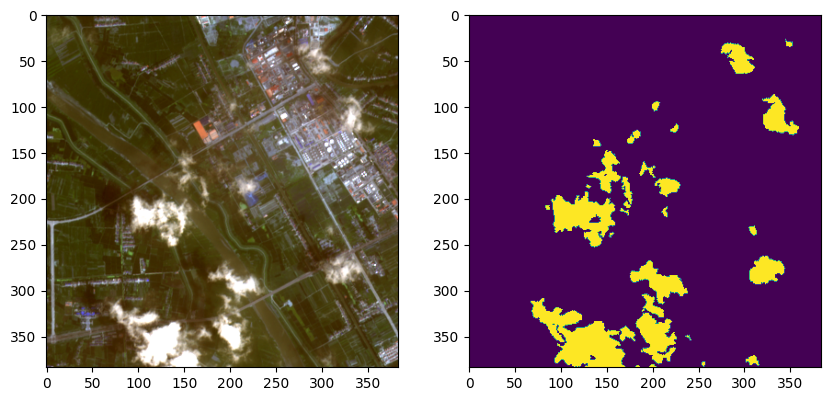

In [ ]:
x, y = data[1000] #34
x = get_normal_picture(x)
ig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(x.permute(1,2,0))
ax[1].imshow(y)

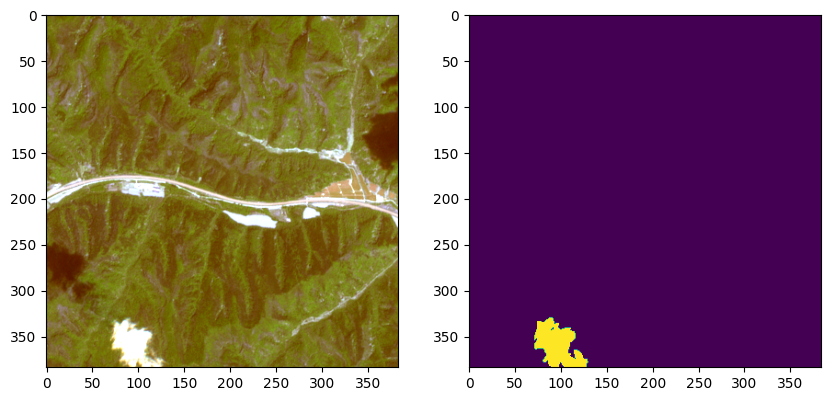

In [ ]:
x, y = data[137]
x = get_normal_picture(x)
ig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(x.permute(1,2,0))
ax[1].imshow(y)

In [ ]:
#Dato che voglio dare un peso diverso nel training ai pixel nuvola e non nuvola, conto
#quanti sono i pixel 1 e 0 nelle label

def count_pixels(data):
  num_clouds = 0
  num_not = 0
  for i in range(len(data)):
    array = data.open_mask(i).flatten() #trasformo ogni maschera in un array monodimensionale per contare agevolmente i pixel
    nc = np.count_nonzero(array)
    nn = len(array) - nc
    num_clouds += nc
    num_not += nn
  return (num_not, num_clouds)



In [ ]:
num_not, num_clouds = count_pixels(data)
print("numero non nuvole:", num_not)
print("numero nuvole:", num_clouds)

numero non nuvole: 225191970
numero nuvole: 6019038


In [ ]:
print(1/(num_not/num_clouds))

0.026728475264903982


In [ ]:
train_ds, valid_ds = torch.utils.data.random_split(data, (1200, 368), generator=torch.Generator().manual_seed(10))

train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)
test_dl = DataLoader(test_data, batch_size = 12, shuffle = True)
# xb, yb = next(iter(train_dl))
# print(xb.shape)
# print(yb.shape)



In [ ]:
import torch

#SEMPLICE UNET

class UNET(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        #blocchi di contrazione (convoluzioni con stride che riducono la dimensione delle immagini)
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        #deconvoluzioni che espandono la dimensione delle immagini
        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = torch.nn.Sequential(
                            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return expand


In [ ]:
#CHECKPOINT IN CUI SALVO GLI AVANZAMENTI DEL TRAINING

CHECKPOINT_PATH = './saved_models'
model_name = 'UNET'
os.makedirs(CHECKPOINT_PATH, exist_ok=True)


In [ ]:
from sklearn.metrics import f1_score

import time
def train(model, model_name, train_dl, valid_dl, loss_fn, optimizer, acc_fn, ignore = False, epochs=1):
    start = time.time()

    last_epoch = 0
    file_exists = os.path.isfile(CHECKPOINT_PATH + '/' + model_name)
    if file_exists and not ignore:
      checkpoint = torch.load(CHECKPOINT_PATH + '/' + model_name)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      last_epoch = checkpoint['epoch']
      loss = checkpoint['loss']
      train_loss = checkpoint['train_loss']
      train_acc = checkpoint['train_acc']
      valid_loss = checkpoint['valid_loss']
      valid_acc = checkpoint['valid_acc']

    if torch.cuda.is_available():
      model.cuda()
    else:
      model.cpu()

    if not file_exists or ignore:
      train_loss, valid_loss = [], []
      train_acc, valid_acc = [], []

    best_acc = 0.0


    for epoch in range(last_epoch, epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
                dataloader = train_dl
            else:
                model.train(False)
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0


            for x, y in dataloader:
                x = x.cpu() if not torch.cuda.is_available() else x.cuda()
                y = y.cpu() if not torch.cuda.is_available() else y.cuda()

                step += 1
                print(step)

                if phase == 'train':

                    optimizer.zero_grad()

                    outputs = model(x)

                    #print(outputs.shape)
                    #print(y.shape)
                    loss = loss_fn(outputs, y)


                    loss.backward()

                    optimizer.step()



                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y)

                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size

                if step % 10 == 0:
                    #print('ciao')

                    print('Current step: {}  Loss: {}  Acc: {}'.format(step, loss, acc))


            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_acc.append(epoch_acc) if phase == 'train' else valid_acc.append(epoch_acc)

            if phase == 'valid':

              torch.save({
                'epoch': epoch + 1, #così riprende da quella dopo
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss, #ultima loss di validation
                'valid_loss': valid_loss,
                'train_loss': train_loss,
                'valid_acc': valid_acc,
                'train_acc': train_acc
                }, CHECKPOINT_PATH + '/' + model_name)


    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return train_loss, valid_loss, train_acc, valid_acc

def acc_metric(predb, yb):
    predb = predb.argmax(1).flatten()
    yb = yb.flatten()
    #ritorna l'f1 score
    return f1_score(yb, predb)
  #print(predb.argmax(1).shape)
  #print(yb.shape)
  #return (predb.argmax(dim=1) == (yb.cpu() if not torch.cuda.is_available() else yb.cuda())).float().mean()


In [ ]:
model = UNET(4, 2)
loss_fn = torch.nn.CrossEntropyLoss(weight = torch.tensor([0.026,1])) #rapporto positive e negative
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:


train_loss, valid_loss, train_acc, valid_acc = train(model, model_name, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs= 30, ignore = False)

print("VALID_LOSS:",valid_loss)
print("TRAIN_LOSS",train_loss)
print("VALID_ACCURACY",valid_acc)
print("TRAIN_ACCURACY",train_acc)


Epoch 25/29
----------
1
2
3
4
5
6
7
8
9
10
Current step: 10  Loss: 0.03331295773386955  Acc: 0.715653878465416
11
12
13
14
15
16
17
18
19
20
Current step: 20  Loss: 0.04165218025445938  Acc: 0.7347625052543086
21
22
23
24
25
26
27
28
29
30
Current step: 30  Loss: 0.051712408661842346  Acc: 0.6296919044557638
31
32
33
34
35
36
37
38
39
40
Current step: 40  Loss: 0.03236427158117294  Acc: 0.8388228910516168
41
42
43
44
45
46
47
48
49
50
Current step: 50  Loss: 0.03421412408351898  Acc: 0.41038420288940763
51
52
53
54
55
56
57
58
59
60
Current step: 60  Loss: 0.03796304389834404  Acc: 0.6759551989832393
61
62
63
64
65
66
67
68
69
70
Current step: 70  Loss: 0.03719228506088257  Acc: 0.6810261173914125
71
72
73
74
75
76
77
78
79
80
Current step: 80  Loss: 0.05026569217443466  Acc: 0.6934860050890586
81
82
83
84
85
86
87
88
89
90
Current step: 90  Loss: 0.02424604631960392  Acc: 0.586394249816062
91
92
93
94
95
96
97
98
99
100
Current step: 100  Loss: 0.10575925558805466  Acc: 0.68573365796

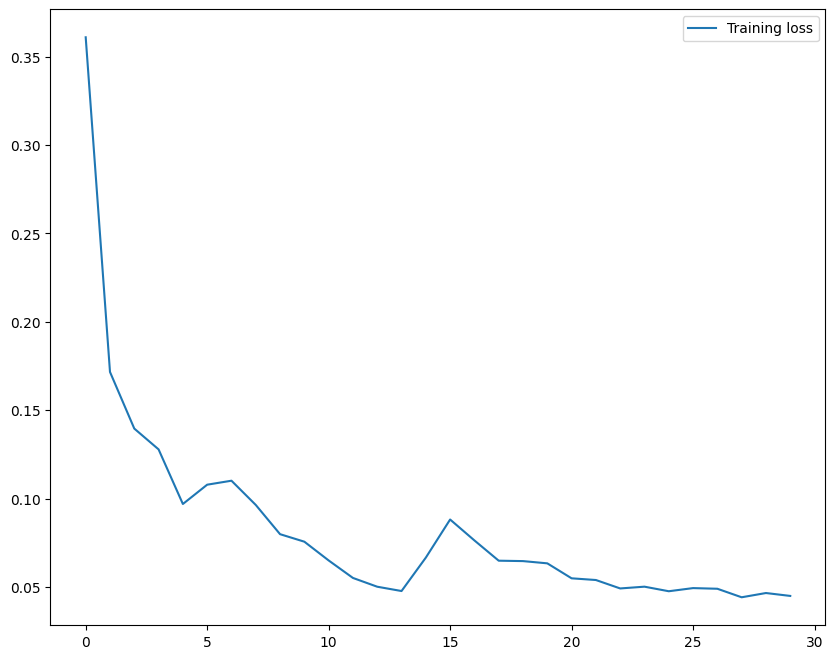

In [ ]:
with torch.no_grad():
  plt.figure(figsize=(10,8))
  plt.plot(train_loss, label='Training loss')
  plt.legend()

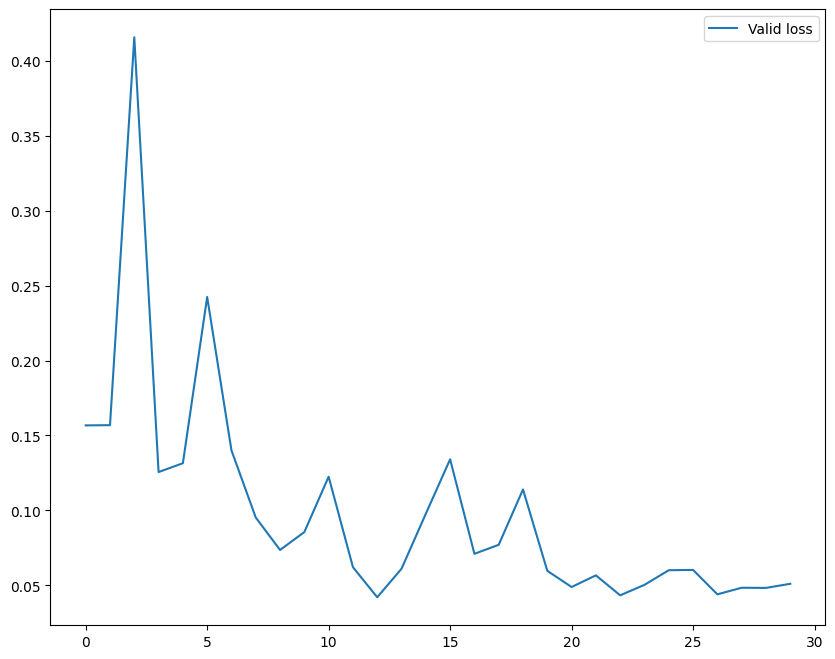

In [ ]:

plt.figure(figsize=(10,8))
#plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

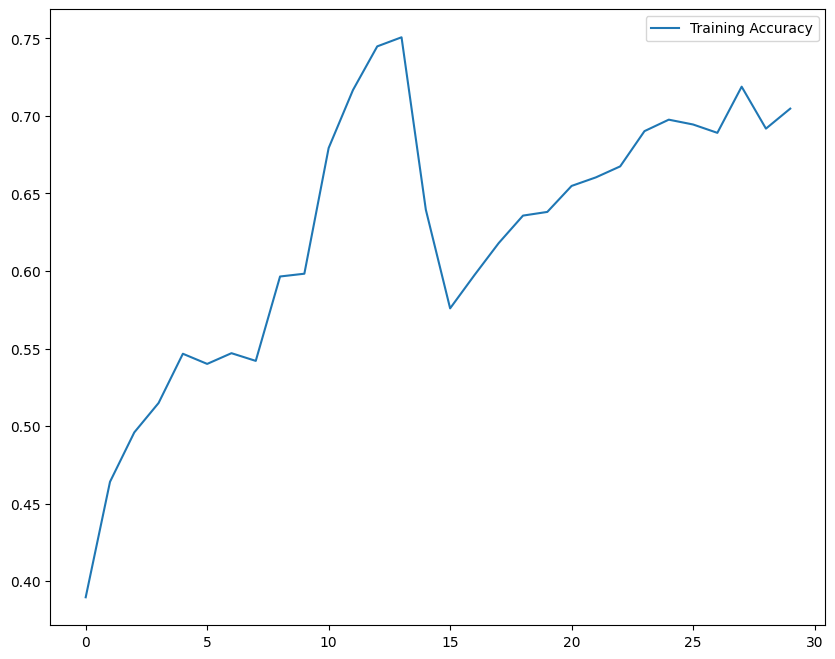

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_acc, label='Training Accuracy')
plt.legend()

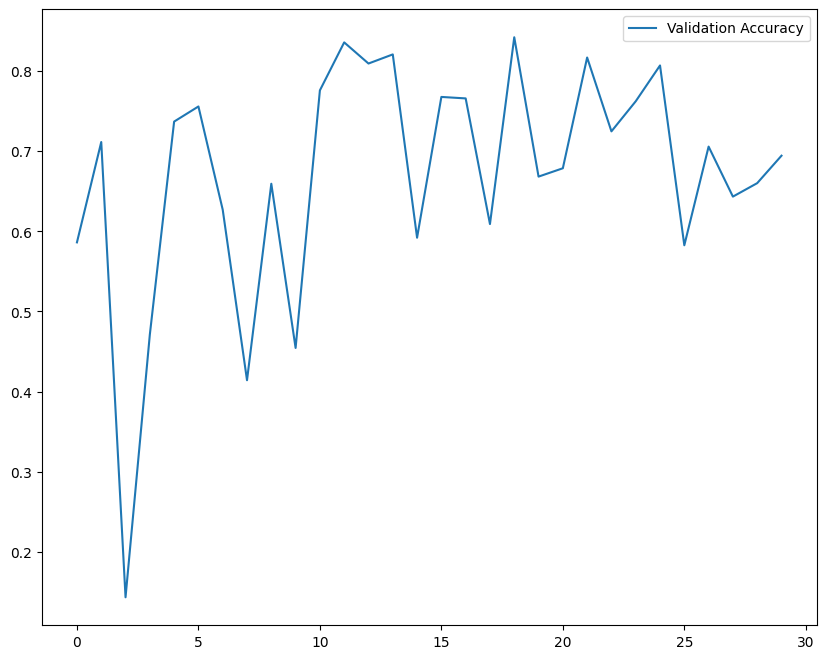

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()

In [ ]:
def batch_to_img(xb, idx):
    #img = np.array(xb[idx,0:4])
    #return img.transpose((1,2,0))
    img = xb[idx,0:4]
    return get_normal_picture(img)


def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()



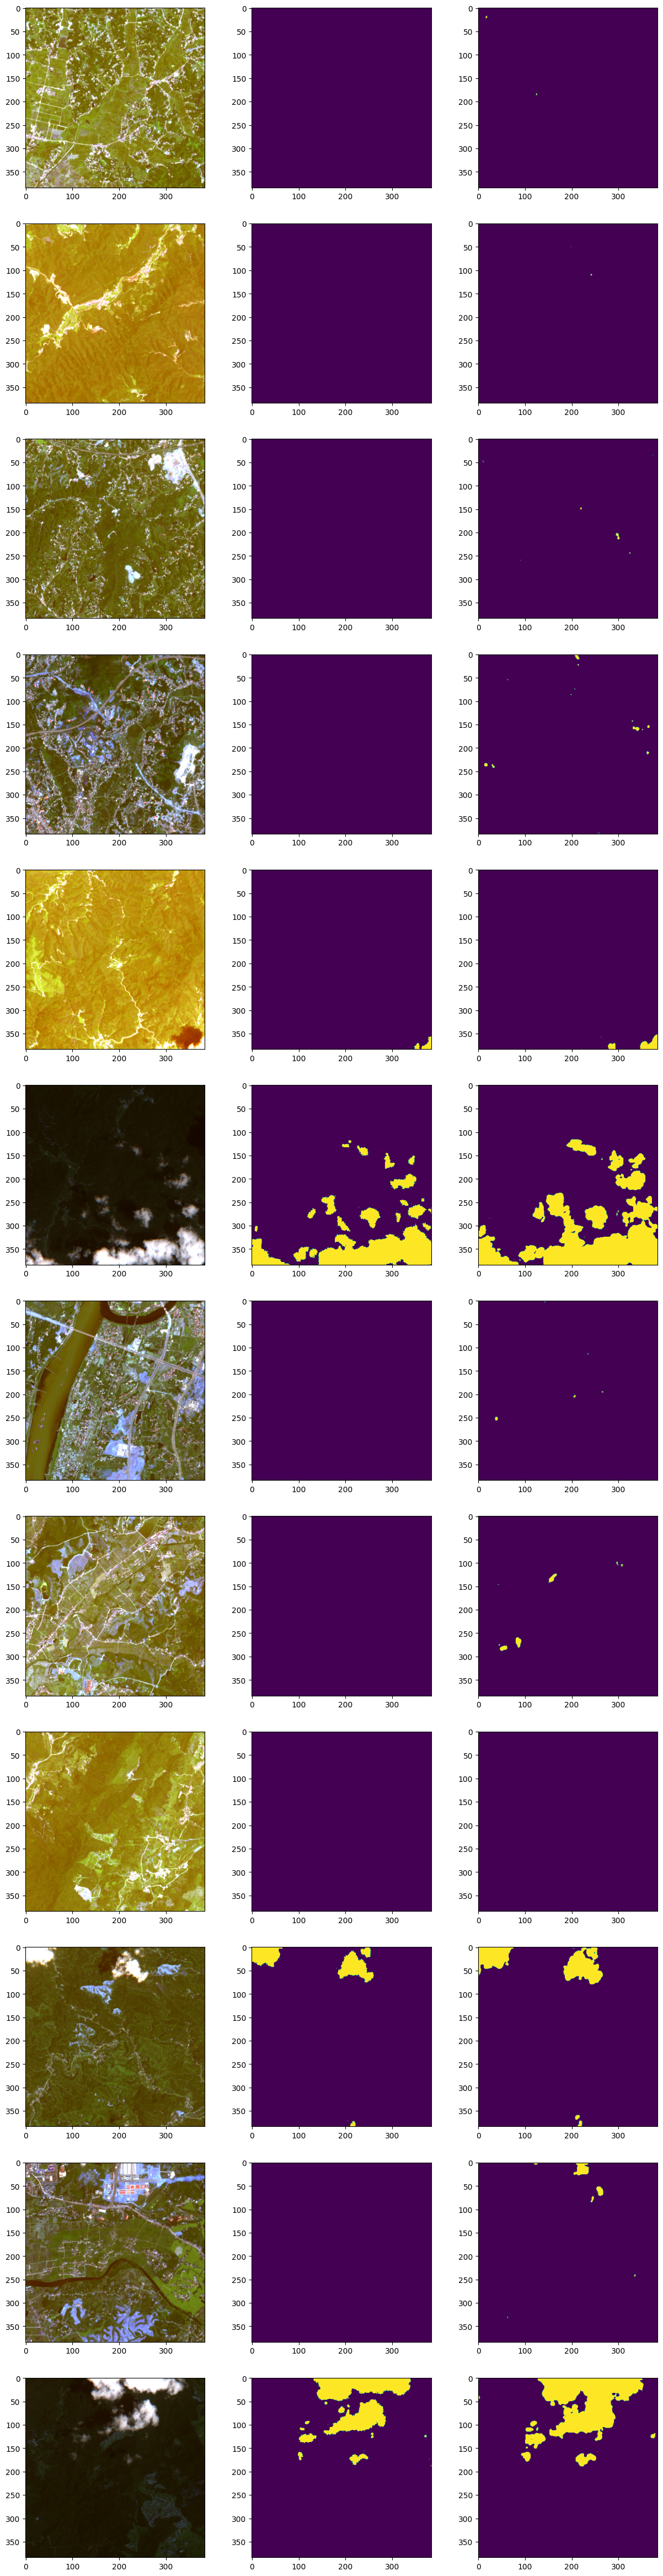

In [ ]:
xb, yb = next(iter(test_dl))

with torch.no_grad():
    predb = model(xb.cpu())

mask = predb_to_mask(predb, 10)
#if(mask.detach().numpy().any() == 1):
  #print('ok')
#elif(mask.detach().numpy().all() == 0):
  #print('no')

bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i).permute(1,2,0))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))



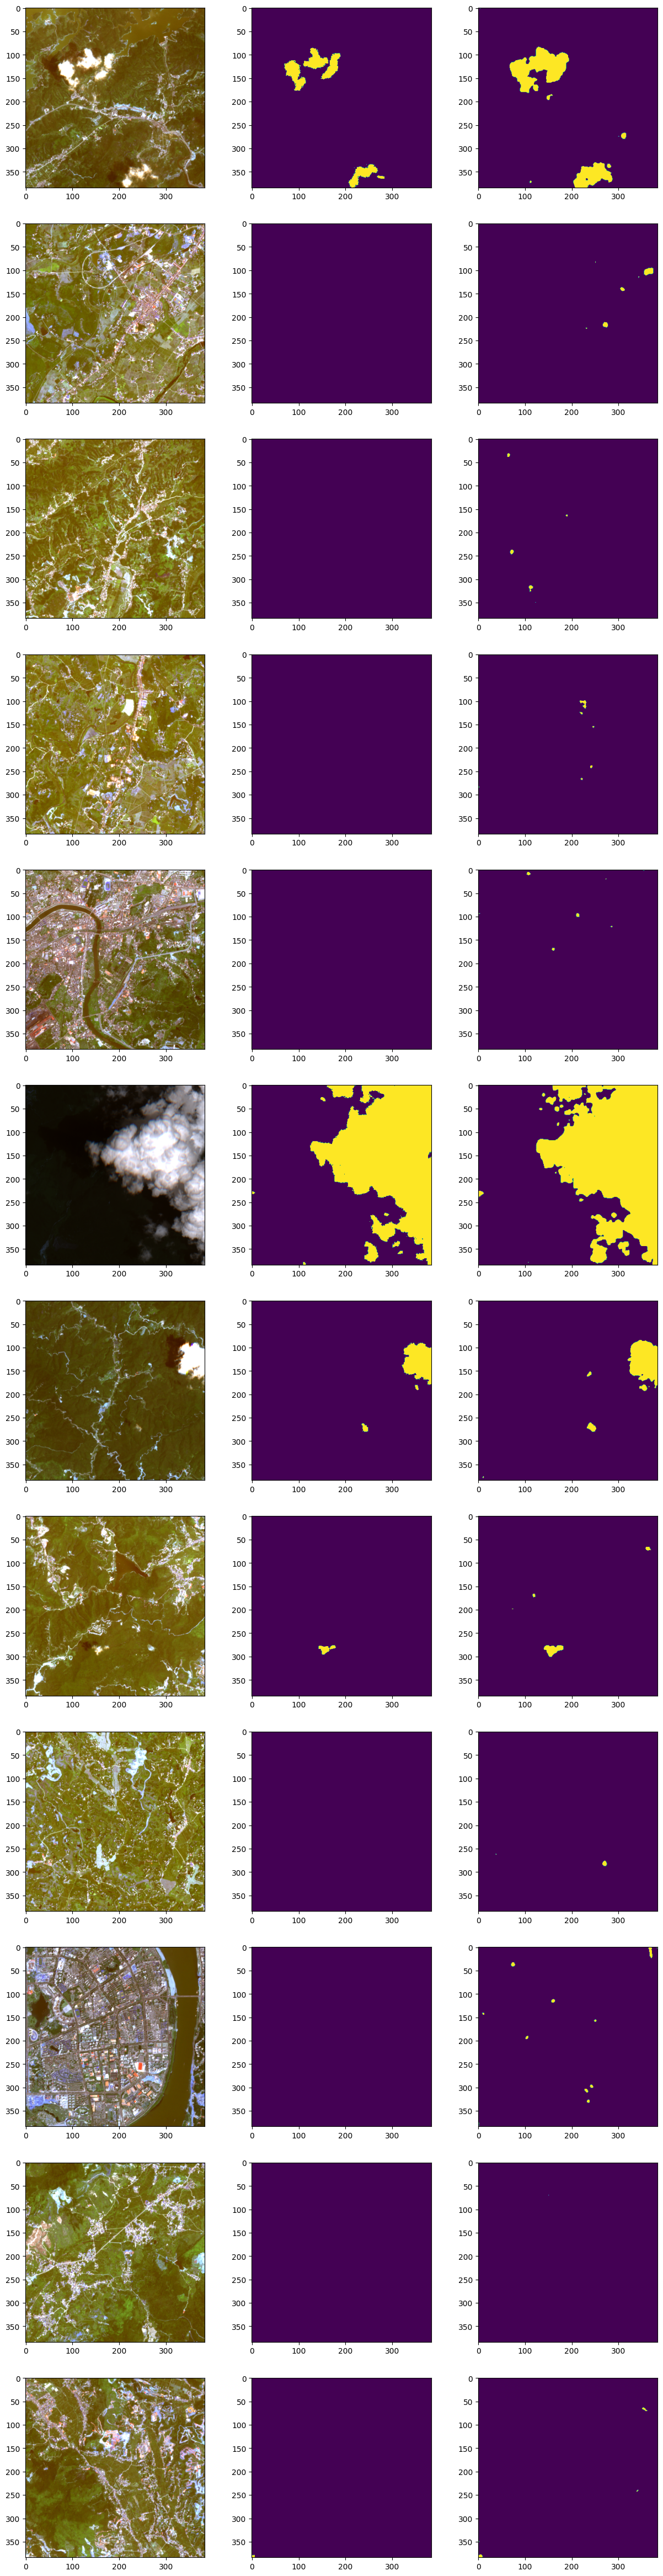

In [ ]:
xb, yb = next(iter(test_dl))

with torch.no_grad():
    predb = model(xb.cpu())

mask = predb_to_mask(predb, 10)
#if(mask.detach().numpy().any() == 1):
  #print('ok')
#elif(mask.detach().numpy().all() == 0):
  #print('no')

bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i).permute(1,2,0))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))